# Explore Qutip Stochastic Solver and Parametric Kerr Oscillators

Motivation: I want to understand properly the qutip stochastic solver. 

How to start? What is the spherical cow of a problem that I should completely understand to benchmark what is going on? 

What is relation of Lindblad, Monte Carlo, and Stochastic solver, and what is the relation of these to measurement collapse? 

Because, in the end, this is what it is all about, right? 

## First step: google, reading

It's probably important for me to do some first deeper reading into what to expect. 

Maybe a good start is this:

https://docs.qojulia.org/stochastic/schroedinger/

qoJulia seems to have more developed documentation that QuTiP. 

They reference me to this book, which is under the evil restrictions of Springer: 

https://link.springer.com/book/10.1007/978-3-540-47620-7

But with sufficient clicking, I can read it online at least:

https://ebookcentral-proquest-com.tudelft.idm.oclc.org/lib/delft/reader.action?docID=3087568

I am unfortunately not much wiser as a result :) But I think I might start with this notebook since it's probably most closely related to running projects: 

https://nbviewer.org/urls/qutip.org/qutip-tutorials/tutorials-v4/time-evolution/018_measures-trajectories-cats-kerr.ipynb


# Kerr oscillator Stochastic

So, let's start with the qutip tutorial. I must say I got lost straight away here:

> 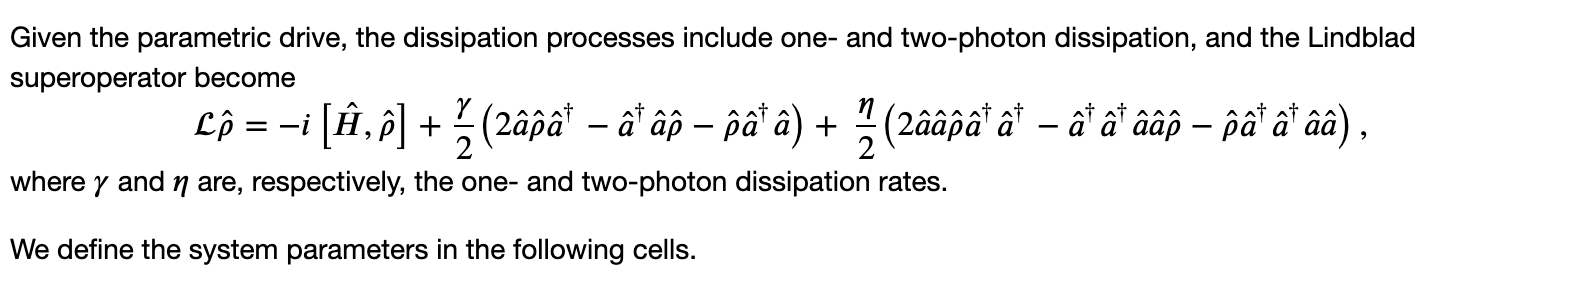

I miss the image in their notebook, but I presume that this is a cavity which is connected to an input-output line with a coupling rate $\gamma$. In other words, single photon hopping into the transmission line. 

And then, the "two photon driving" is produced by flux modulation of the inductance by an (infinitely stiff) pump at 2 $\omega$ (3-wave mixing), or, as in our case, by 4-wave mixing combined with a bichromatic pump on the input-output port.

But in this picture, in the lab frame, there is (?) no two photon loss! There is only single-photon hoppping decay out to the input-output line (or into a second blind loss channel if we want to incorporate internal loss). 

So where does $\eta$ come from? And what determines it's value if I have a system that has only single photon loss and a two photon driving strenght in the "lab" frame? 

These answers are not clear to me. For now, though, I will maybe just continue blindly and play with parameters to see what happens. 

And, actually, to start, I will just explore the eigenstates of the Hamiltonian.

In [71]:
from qutip import *
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation

In [70]:
plt.rcParams["animation.html"] = "jshtml"

### Explore Hamiltonian and Eigenstates

The physics should be symmetric on positive and negative Kerr, and negative Kerr gives unphysical solutions for large Hilbert spaces, so we'll stick to just positive Kerr. 

We'll also make it dimensionless: measure two photon driving `eps` in units of Kerr. 

In [193]:
def plot_vals_states(H):
    vals,states = H.eigenstates()
    n = range(N)
    fig = plt.figure(figsize=(12,5))
    plt.subplot(121)
    plt.plot(n[0:10], vals[0:10], '.-')
    point, = plt.plot(0, vals[0], 'o')
    plt.subplot(122)
    ax = plt.gca()
    def update(i):
        ax.cla() # Clear axis. Without this, generating the animation takes a lot longer...
        plot_wigner(states[i],fig=fig,ax=ax)
        point.set_data((n[i],), (vals[i],))
        print(".",end="")
    anim = FuncAnimation(fig, update, frames=10)
    plt.close(fig)
    return anim, vals, states

In [191]:
N = 50
a = destroy(N)

eps = 10 # Two photon drive strength
H = a.dag()*a.dag()*a*a + eps*(a*a + a.dag()*a.dag())

anim, vals, states = plot_vals_states()
anim

...........

See what happens as we sweep the two photon drive, transition from regular Kerr to Kerr cats:

In [171]:
N = 50
a = destroy(N)

all_vals = []
all_states = []

eps_vals = np.linspace(0,10,20)

for eps in eps_vals:
    H = a.dag()*a.dag()*a*a + eps*(a*a + a.dag()*a.dag())
    vals,states = H.eigenstates()
    all_vals.append(vals)
    all_states.append(states)

all_vals = np.array(all_vals)

OK, this really blew my mind: why are first two states degenerate, always?

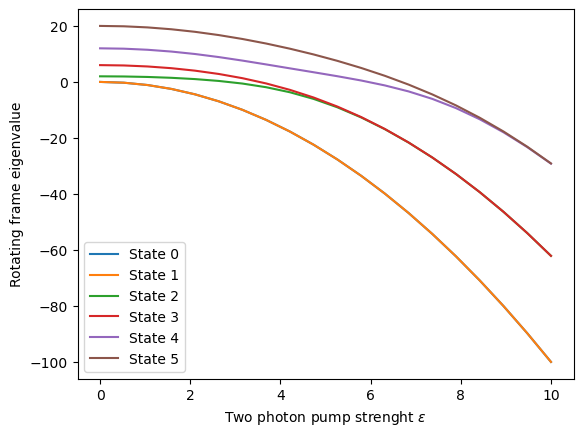

In [172]:
for i in range(6):
    plt.plot(eps_vals,all_vals[:,i], label="State %d" % i);
plt.ylabel("Rotating frame eigenvalue")
plt.xlabel(r"Two photon pump strenght $\epsilon$")
plt.legend()
plt.show()

But then I remembered: **we're in the rotating frame!** In the rotating frame, with the Kerr Hamiltonian written as a.dag a.dag a a, the ground state and the first excited state of the Kerr oscillator on its own are degenerate. 

If I want to calculate **lab frame eigenenergies**, I need to add the oscillator frequency to the Hamiltonian. (And probably use the another Kerr term which includes the Lamb shift). But the latter is a small effect. Let's assume weak anaharmonicity and take the lab frequency to be 10 times the Kerr. 

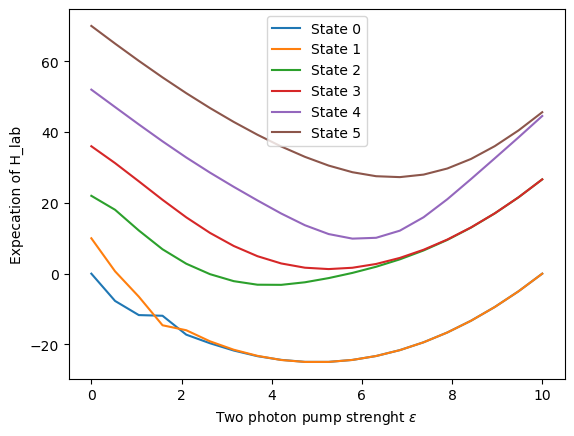

In [173]:
H_lab = a.dag()*a.dag()*a*a + eps*(a*a + a.dag()*a.dag()) + 10*a.dag()*a
E_lab = []
for i in range(len(eps_vals)):
    E_lab.append(expect(H_lab, all_states[i]))

E_lab = np.array(E_lab)

for i in range(6):
    plt.plot(eps_vals,E_lab[:,i], label="State %d" % i);
plt.ylabel("Expecation of H_lab")
plt.xlabel(r"Two photon pump strenght $\epsilon$")
plt.legend()
plt.show()

Ah, yes, pretty cool! I guess though the question is: what do these energies really mean? At zero two-photon pump strength, the difference between the eigenfrequencies specifies the frequency at which the states will be able to emit or absorb radiation. 

But that cannot be the case here: at high two photon pump strength, the eigenstates are (or at least can be written as) coherent states, and coherent states will radiate into the output port at the oscillator frequency. But if I take the above literally, then at high powers, a superposition of the blue and orange line states will emit at zero frequency. Which is nonsense. 

I guess though that the above logic does not hold if there is not a dipole matrix element connecting the states, which I guess there is not. (Clearly there is not: I can't get from one coherent state to the other using a creation operator.)

I guess that what I need to do is to look at the spectrum of those states for, for example, the a+a.dag operator. This will tell me what is going on, I guess? 
 
Or not, I tried it and got what looks like nonsense. Hmmm. Let's move on to orthogonal drives. 

In [200]:
N = 50
a = destroy(N)

eps_lin = 0.1*1j
eps = 2 # Two photon drive strength

H = a.dag()*a.dag()*a*a + eps*(a*a + a.dag()*a.dag()) + eps_lin*(a+a.dag())

anim, vals, states = plot_vals_states(H)
anim

..

/Users/gsteele/micromamba/envs/nbgrader/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


.........